![AIAP Banner](../../imgs/AIAP-Banner.png "AIAP Banner")

<h1><center>
    <br>
    Time-Series Forecasting - Weather Data</center></h1>

# 1. Introduction

This notebook presents the Exploratory Data Analysis (EDA) phase of a time series forecasting project aimed at predicting Singapore’s average rainfall amount for a future time period (e.g., the next 24 hours). The objective is to develop an end-to-end machine learning pipeline using historical weather data sourced from Singapore’s public weather API.

This EDA will help us understand the structure and characteristics of the dataset, identify temporal patterns and anomalies, and prepare relevant features for model training. Specifically, this phase will involve:

- Parsing and aggregating rainfall data across all regions in Singapore.
- Visualizing temporal trends, seasonality, and potential outliers.
- Assessing data completeness, stationarity, and correlation structures.
- Preparing the dataset for downstream modeling tasks.

Insights gained from this analysis will inform the selection and configuration of at least three forecasting models to be evaluated later in the pipeline, including classical statistical models (e.g., ARIMA) and deep learning approaches (e.g., LSTM, RNN, Transformer-based architectures).



# 2. EDA

Importing the necessary libraries.

In [3]:
%load_ext autoreload
%autoreload 2

# ===== Standard Library =====
import os
import re
from typing import List

# ===== Third-Party Libraries =====
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from hydra import compose, initialize
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# ===== Local Application/Library Specific =====
from src.data_loader import load_and_concatenate
from src.data_processor import (
    impute_missing_values,
    merge_hourly_features,
    process_feature_folder
)
from src.general_utils import set_global_seed

Here we load the individual files for the historical data and combine them into their individual feature files and merge all the data for all 5 features into a single file.

Here we load the necessary environment variables

In [2]:
# Load environment variables
load_dotenv()

True

Loading the config file

In [ ]:
# Initialize Hydra and set config path
initialize(config_path="conf", version_base="1.3.2")

# Compose the config
cfg = compose(config_name="config")


Setting the random seeds for reproducibility

In [ ]:
set_global_seed()

Here we read the individual files for the historical data, combine them by feature, and load it into dataframes by feature.

In [5]:
df_list = load_and_concatenate(['data/rainfall', 'data/humidity', 'data/temperature', 'data/wind_direction', 'data/wind_speed'])


[INFO] Reading: HistoricalRainfallacrossSingapore2017.csv from data/rainfall
[INFO] Reading: HistoricalRainfallacrossSingapore2018.csv from data/rainfall
[INFO] Reading: HistoricalRainfallacrossSingapore2019.csv from data/rainfall
[INFO] Reading: HistoricalRainfallacrossSingapore2020.csv from data/rainfall
[INFO] Reading: HistoricalRainfallacrossSingapore2021.csv from data/rainfall
[INFO] Reading: HistoricalRainfallacrossSingapore2022.csv from data/rainfall
[INFO] Reading: HistoricalRainfallacrossSingapore2023.csv from data/rainfall
[INFO] Reading: HistoricalRainfallacrossSingapore2024.csv from data/rainfall
[SUCCESS] data/rainfall: 8 files, 48538713 rows
[INFO] Reading: HistoricalRelativeHumidityacrossSingapore2017.csv from data/humidity
[INFO] Reading: HistoricalRelativeHumidityacrossSingapore2018.csv from data/humidity
[INFO] Reading: HistoricalRelativeHumidityacrossSingapore2019.csv from data/humidity
[INFO] Reading: HistoricalRelativeHumidityacrossSingapore2020.csv from data/humid

In [ ]:
rainfall_df, humidity_df, temperature_df, wind_direction_df, wind_speed_df = df_list

We set the index to be the timestamp for Time Series Analysis.

In [5]:
for df in df_list:
    df["timestamp"] = pd.to_datetime(df["timestamp"])  # ensure correct dtype
    df.set_index("timestamp", inplace=True)

Some basic statistics about the data.

In [49]:
for df in df_list:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48538713 entries, 0 to 48538712
Data columns (total 12 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   date                      object 
 1   timestamp                 object 
 2   update_timestamp          object 
 3   station_id                object 
 4   station_name              object 
 5   station_device_id         object 
 6   location_longitude        float64
 7   location_latitude         float64
 8   reading_update_timestamp  object 
 9   reading_value             float64
 10  reading_type              object 
 11  reading_unit              object 
dtypes: float64(3), object(9)
memory usage: 4.3+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57079808 entries, 0 to 57079807
Data columns (total 11 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   date                      object 
 1   timestamp                 object 
 2   update_time

Here we visualize the raw values.

In [6]:
def plot_reading_values(
    df_list: List[pd.DataFrame],
    titles: List[str],
    output_dir: str = "images"
) -> None:
    """
    Plot and save 'reading_value' vs datetime index for each DataFrame.

    Args:
        df_list (List[pd.DataFrame]): List of DataFrames to plot.
        titles (List[str]): List of titles corresponding to each plot.
        output_dir (str): Directory to save plots (default: 'plots').
    """
    os.makedirs(output_dir, exist_ok=True)

    for df, title in zip(df_list, titles):
        plt.figure(figsize=(12, 4))
        plt.plot(df.index, df["reading_value"], linewidth=0.5)
        plt.title(f"{title} - Reading Value Over Time")
        plt.xlabel("Timestamp")
        plt.ylabel("Reading Value")
        plt.grid(True)
        plt.tight_layout()

        # Save to file
        safe_title = re.sub(r"[^\w\-]+", "_", title.lower())  # sanitize filename
        filepath = os.path.join(output_dir, f"{safe_title}.png")
        plt.savefig(filepath)
        print(f"[INFO] Saved plot to: {filepath}")

        # Show plot (optional)
        plt.show()

[INFO] Saved plot to: images/rainfall.png


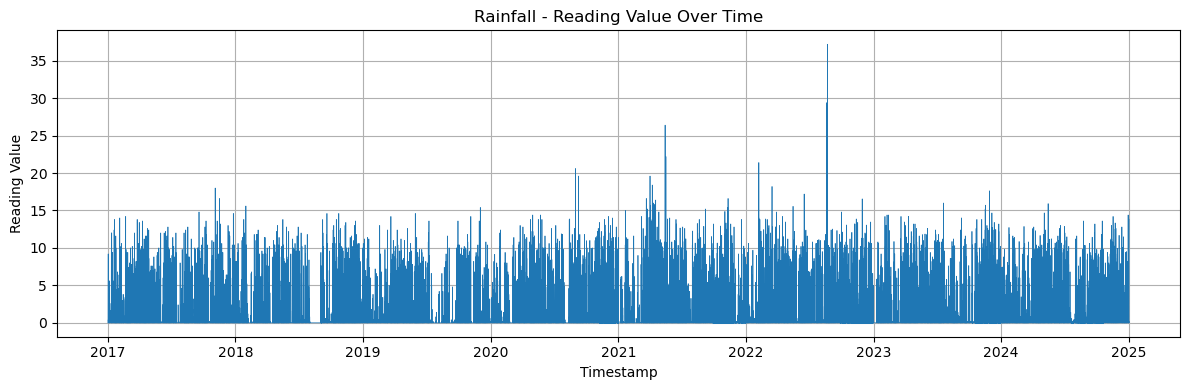

[INFO] Saved plot to: images/humidity.png


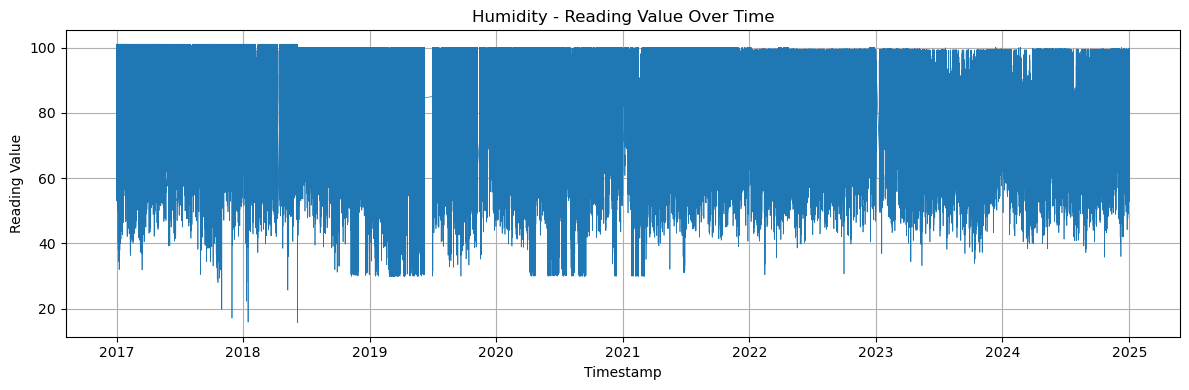

[INFO] Saved plot to: images/temperature.png


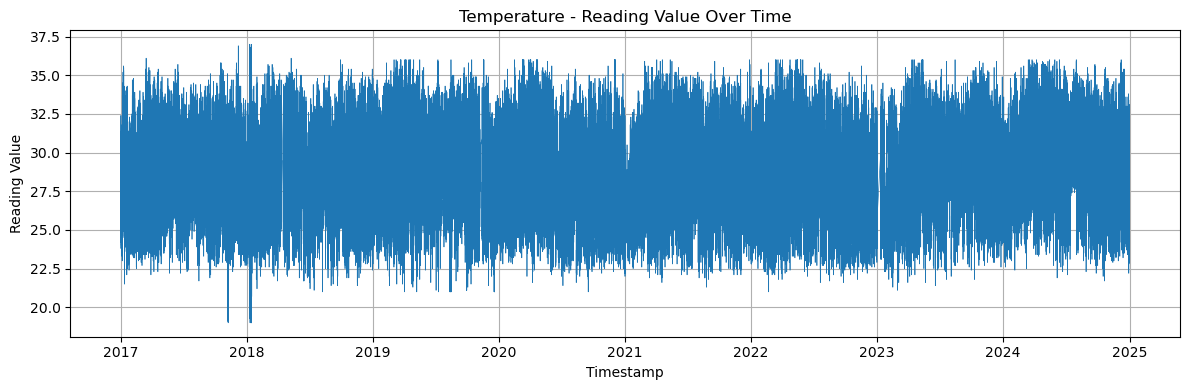

[INFO] Saved plot to: images/wind_direction.png


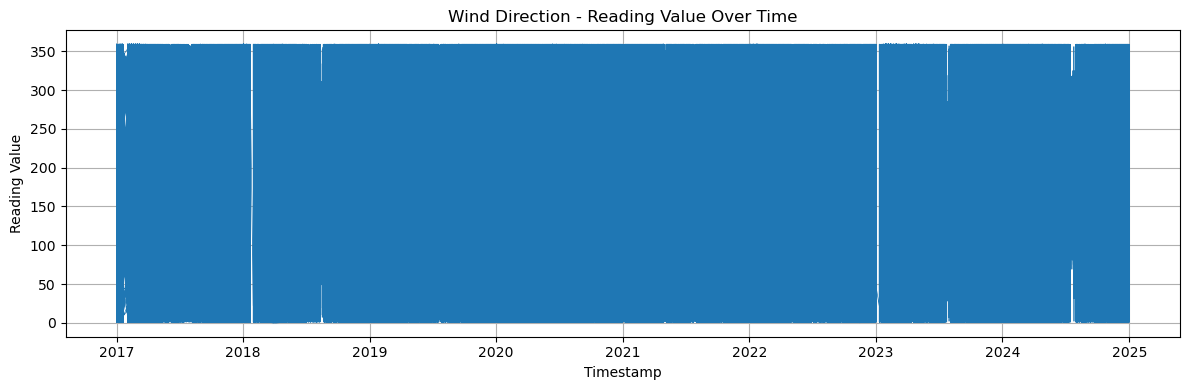

[INFO] Saved plot to: images/wind_speed.png


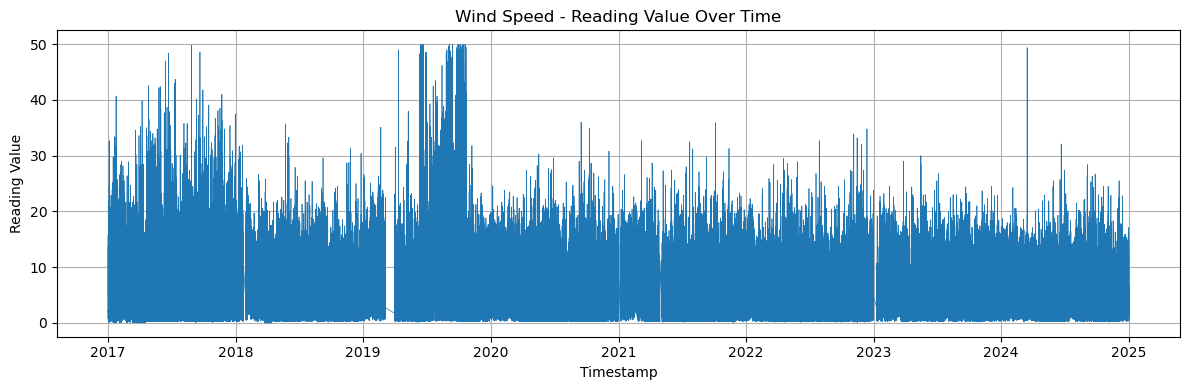

In [7]:
titles = ["Rainfall", "Humidity", "Temperature", "Wind Direction", "Wind Speed"]
plot_reading_values(df_list, titles)

We note that there appears to be missing values, and that the features are of different scale.

In particular, wind direction is in degrees, 0 - 360, and we should therefore apply a circular encoding (sine/consine transformation) to this feature to capture the cyclic nature of the feature.

Here we perform resampling of the data into hourly features for the purpose of hour 24-hour prediction objective.

In [ ]:
base_path = "./data"  # Replace with your actual folder path
output_path = "./data/aggregated"  # Output folder for processed files
os.makedirs(output_path, exist_ok=True)

features = ["humidity", "rainfall", "temperature", "wind_direction", "wind_speed"]
for feature in features:
    process_feature_folder(
        folder_path=os.path.join(base_path, feature),
        output_path=output_path,
        feature=feature,
    )

[INFO] Reading file: HistoricalRelativeHumidityacrossSingapore2017.csv
[INFO] Reading file: HistoricalRelativeHumidityacrossSingapore2018.csv
[INFO] Reading file: HistoricalRelativeHumidityacrossSingapore2019.csv
[INFO] Reading file: HistoricalRelativeHumidityacrossSingapore2020.csv
[INFO] Reading file: HistoricalRelativeHumidityacrossSingapore2021.csv
[INFO] Reading file: HistoricalRelativeHumidityacrossSingapore2022.csv
[INFO] Reading file: HistoricalRelativeHumidityacrossSingapore2023.csv
[INFO] Reading file: HistoricalRelativeHumidityacrossSingapore2024.csv
[SUCCESS] Saved: data/aggregated/humidity_hourly.csv
[INFO] Reading file: HistoricalRainfallacrossSingapore2017.csv
[INFO] Reading file: HistoricalRainfallacrossSingapore2018.csv
[INFO] Reading file: HistoricalRainfallacrossSingapore2019.csv
[INFO] Reading file: HistoricalRainfallacrossSingapore2020.csv
[INFO] Reading file: HistoricalRainfallacrossSingapore2021.csv
[INFO] Reading file: HistoricalRainfallacrossSingapore2022.csv
[

Here we combine the historical data into a single .csv file for each feature

In [ ]:
input_dir = "./data/aggregated"
feature_dfs = {}

for file in os.listdir(input_dir):
    if file.endswith("_hourly.csv"):
        feature = file.replace("_hourly.csv", "")
        df = pd.read_csv(os.path.join(input_dir, file), parse_dates=["timestamp"])
        df.set_index("timestamp", inplace=True)
        df.sort_index(inplace=True)
        
        # Generate complete hourly index and reindex the DataFrame
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="h")
        df = df.reindex(full_index)
        df.index.name = "timestamp"
        
        feature_dfs[feature] = df

Here we visualize the resampled data along with the distribution of the time stamps with missing values.

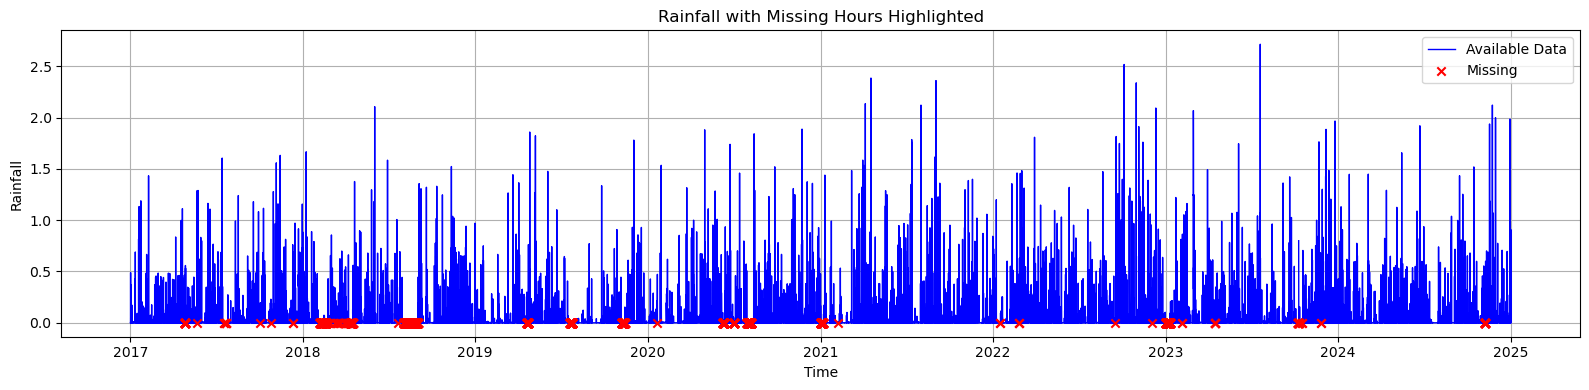

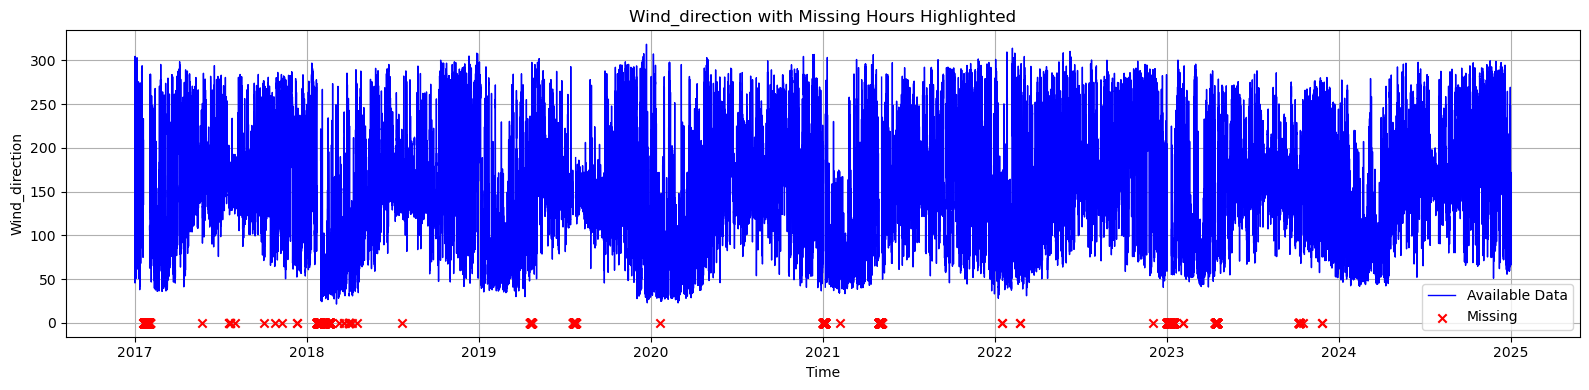

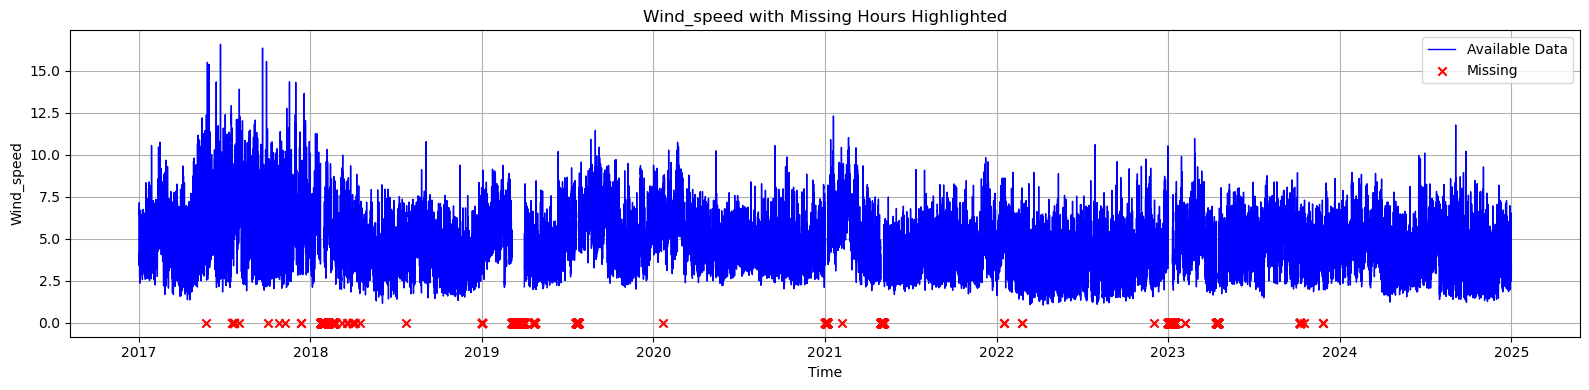

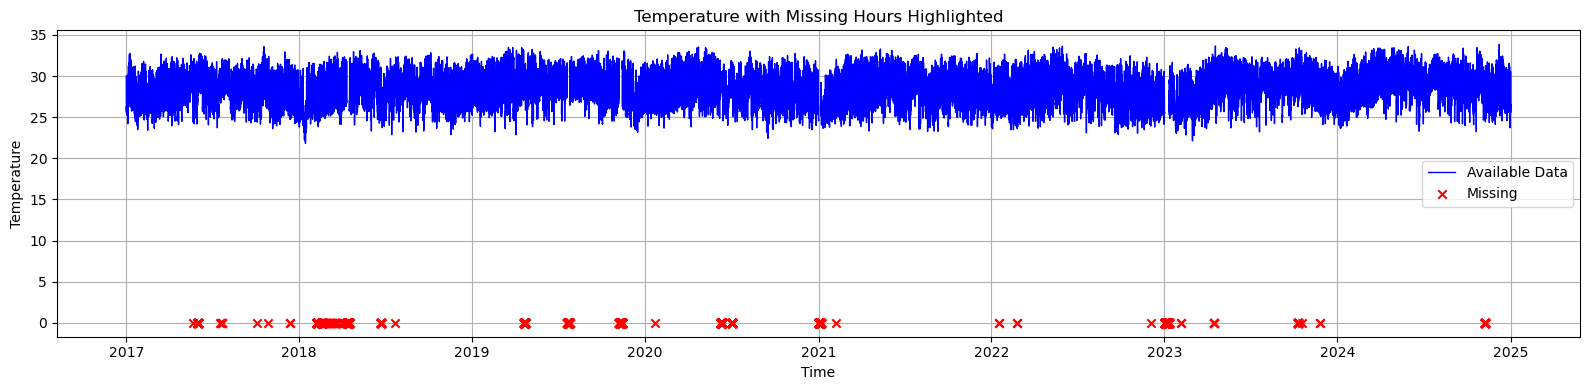

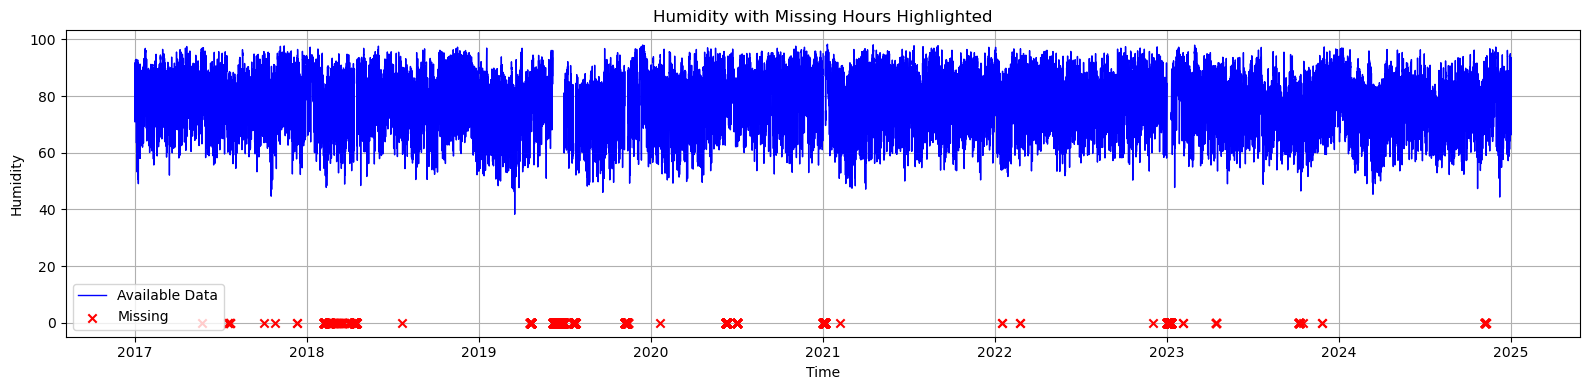

In [ ]:
# Plot each feature's missing data
for feature, df in feature_dfs.items():
    missing_mask = df[feature].isna()

    plt.figure(figsize=(16, 4))
    plt.plot(df.index, df[feature], label="Available Data", color="blue", linewidth=1)
    plt.scatter(df.index[missing_mask], [0]*missing_mask.sum(), 
                label="Missing", color="red", marker="x", zorder=5)

    plt.title(f"{feature.capitalize()} with Missing Hours Highlighted")
    plt.xlabel("Time")
    plt.ylabel(feature.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

We that after resampling, all the features have some timestamps with missing values, and that the missing values appear to be just for a small percentage of the data. Before imputing the missing values, we will combine all the features into a single dataset.

In [20]:
merge_hourly_features(input_dir="./data/aggregated", output_file="./data/aggregated/all_features_hourly.csv")

[INFO] Reading humidity_hourly.csv
[INFO] Reading rainfall_hourly.csv
[INFO] Reading temperature_hourly.csv
[INFO] Reading wind_direction_hourly.csv
[INFO] Reading wind_speed_hourly.csv
[SUCCESS] Merged data saved to: ./data/aggregated/all_features_hourly.csv


Here we check the number of missing values.

In [24]:
df.isna().sum()

humidity          1653
rainfall          2118
temperature       1122
wind_direction    1479
wind_speed        1821
dtype: int64

As the missing values are few, we will use interpolation to fill them and also backfill and values at the begining of the series to fill the gaps left by the interpolation.



In [ ]:
df = impute_missing_values(df)
df.isna().sum()

humidity          0
rainfall          8
temperature       0
wind_direction    0
wind_speed        0
dtype: int64

We note that after interpolation there are still some missing values, likely those at the beginning or the end missed by interpolation.


In [ ]:

df.head(10)

,humidity,rainfall,temperature,wind_direction,wind_speed
timestamp,,,,,
2017-01-01 00:00:00,88.195604,0.0,26.310419,206.352050,3.440088
2017-01-01 01:00:00,88.606864,0.0,26.279535,271.119536,3.890396
2017-01-01 02:00:00,88.993531,0.0,26.128930,285.391459,3.698062
2017-01-01 03:00:00,89.997179,0.0,25.983426,286.939982,3.835526
2017-01-01 04:00:00,90.394872,0.0,25.837500,248.544889,4.195263
2017-01-01 05:00:00,90.851154,0.0,25.761204,279.662246,4.037018
2017-01-01 06:00:00,91.576744,0.0,25.597130,284.097884,3.558772
2017-01-01 07:00:00,90.939496,0.0,25.586262,295.262411,3.818938
2017-01-01 08:00:00,88.902561,0.0,26.329595,304.713393,4.138448


We see that the missing data is the rainfall for the first 8 days of the dataset. We will use back-flling to impute these missing values.

In [ ]:
df = df.bfill()

In [36]:
df.describe()

,humidity,rainfall,temperature,wind_direction,wind_speed
count,70128.000000,70128.000000,70128.000000,70128.000000,70128.000000
mean,79.645413,0.024487,28.028667,156.685845,4.617277
std,9.846979,0.112291,1.970645,63.267184,1.699273
min,38.306189,0.000000,21.824465,21.414835,1.054335
25%,72.869367,0.000000,26.530450,110.798151,3.344710
50%,81.739502,0.000000,27.856607,154.345083,4.390641
75%,87.280913,0.000717,29.424219,202.303044,5.632738
max,98.283019,2.713560,33.863806,318.569444,16.579315


Here we will use the periodogram to check for the dominant frequencies (cycles) in the plot.

/var/folders/jj/5qwj5cnx1gj65x11_1ck_c180000gp/T/ipykernel_2440/2687020120.py:14: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies


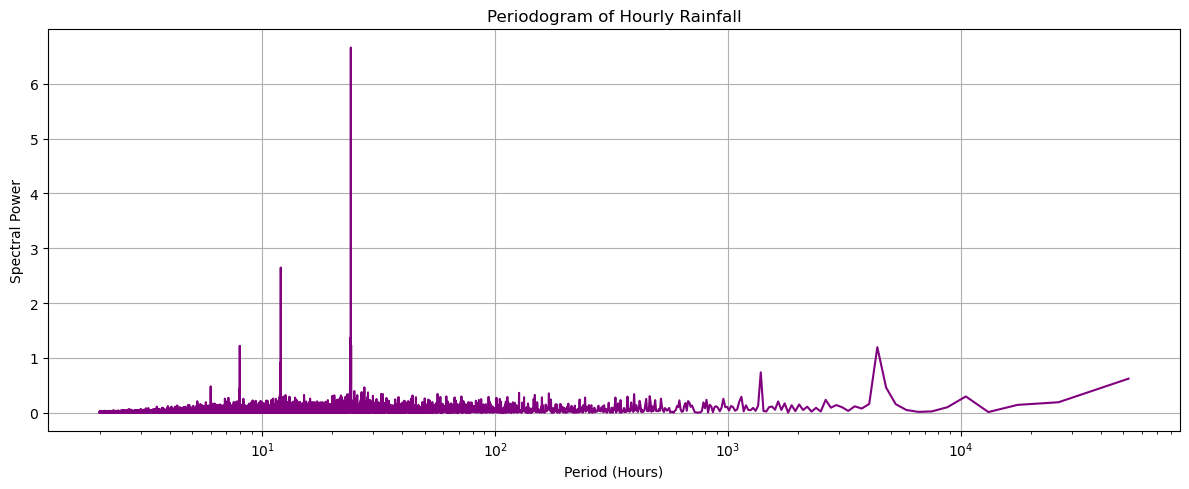

In [ ]:
# Use hourly rainfall data (interpolated)
ts = df["rainfall"].copy()
ts.index = pd.to_datetime(ts.index)
ts = ts.interpolate(method="time")

# Convert to numpy array
signal = ts.values
fs = 1  # Sampling frequency: 1/hour

# Compute periodogram
frequencies, power = periodogram(signal, fs=fs)

# Convert frequency to period (hours)
periods = 1 / frequencies
valid = np.isfinite(periods)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(periods[valid], power[valid], color='purple')
plt.xscale("log")
plt.xlabel("Period (Hours)")
plt.ylabel("Spectral Power")
plt.title("Periodogram of Hourly Rainfall")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Key Observations

1. **Strongest peak at ~24 hours**
   - Indicates a **clear daily cycle** — likely due to diurnal weather patterns (e.g., afternoon showers, temperature-driven convective rainfall).
   - Confirms that **period=24** would be a useful seasonal component for some models.

2. **Secondary peaks around ~12 and ~8 hours**
   - May indicate **sub-daily periodicity**, such as:
     - Double peaks in a day (morning + evening rain),
     - Local weather systems or coastal effects.
   - Worth testing `period=12` or using STL for multi-seasonal decomposition.

3. **Noticeable energy at very long periods (~8000–10000 hours)**
   - Suggests a **yearly pattern** (8760 hours = 365 days).
   - Supports the use of `period=8760` for annual seasonality.
   - These are lower-frequency, broad-spectrum signals.

4. **Noise floor and sharp decay**
   - After the strong peaks, the spectrum flattens, indicating **lower power across non-seasonal frequencies**.
   - This suggests a **combination of structured seasonal effects + randomness**.

Here we perform decomposition of our target series, the rainfall.

Zero or negative values detected. Using 'additive' model.
Using additive model with period=8760


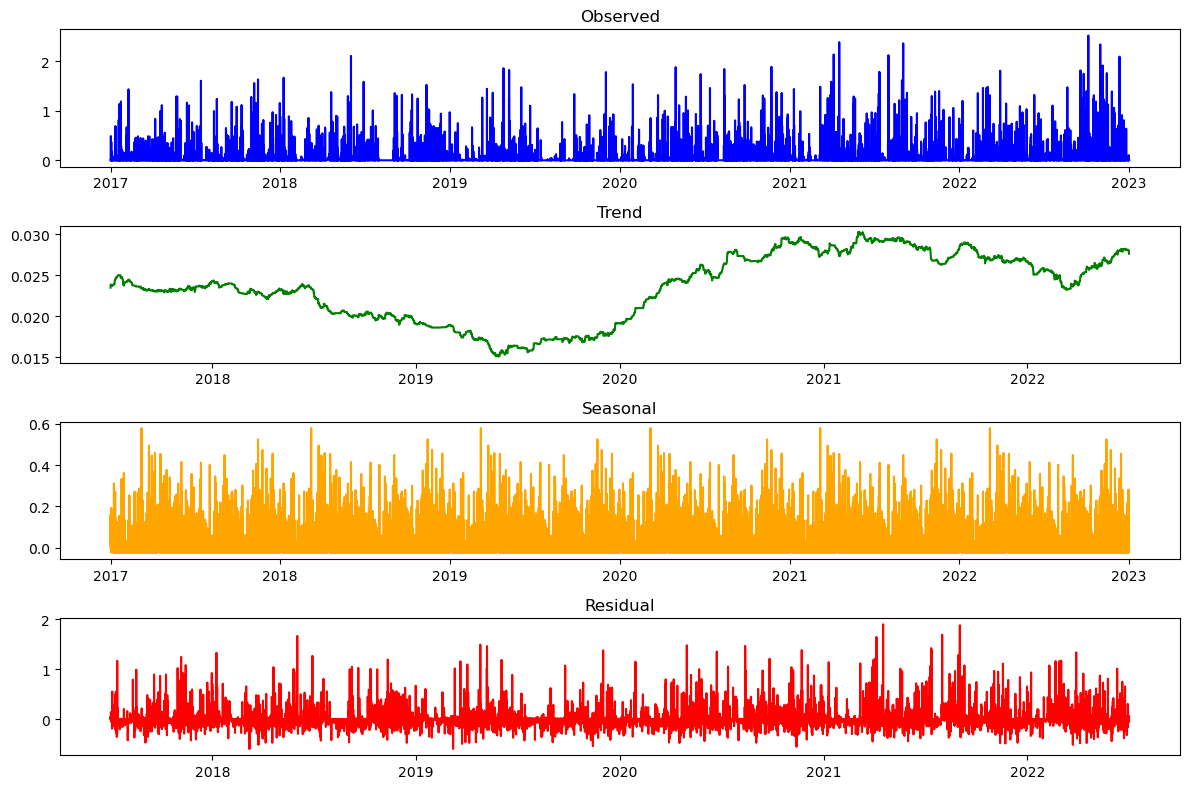

In [ ]:
def check_decomposition_model(ts: pd.Series, window: int = 24 * 30) -> str:
    """
    Suggest 'additive' or 'multiplicative' based on variance-mean correlation,
    but fallback to 'additive' if data contains zero or negative values.
    """
    if (ts <= 0).any():
        print("Zero or negative values detected. Using 'additive' model.")
        return "additive"

    rolling_mean = ts.rolling(window).mean()
    rolling_std = ts.rolling(window).std()
    correlation = rolling_mean.corr(rolling_std)
    print(f"Correlation between rolling mean and std: {correlation:.3f}")

    return "multiplicative" if correlation > 0.5 else "additive"

def plot_decomposition(result):
    """Plot seasonal_decompose result with distinct colors for each component."""
    colors = {
        "observed": "blue",
        "trend": "green",
        "seasonal": "orange",
        "resid": "red"
    }

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(result.observed, color=colors["observed"])
    plt.title("Observed")

    plt.subplot(412)
    plt.plot(result.trend, color=colors["trend"])
    plt.title("Trend")

    plt.subplot(413)
    plt.plot(result.seasonal, color=colors["seasonal"])
    plt.title("Seasonal")

    plt.subplot(414)
    plt.plot(result.resid, color=colors["resid"])
    plt.title("Residual")

    plt.tight_layout()
    plt.show()

def decompose_rainfall(df: pd.DataFrame, period: int = 24 * 365):
    """
    Decomposes the hourly rainfall time series using yearly seasonality.

    Args:
        df (pd.DataFrame): DataFrame with datetime index and 'rainfall' column.
        period (int): Seasonal period to use in hours (default: 8760 for yearly).
    """
    rainfall_ts = df["rainfall"].copy()
    rainfall_ts.index = pd.to_datetime(rainfall_ts.index)

    # Interpolate missing values
    rainfall_ts = rainfall_ts.interpolate(method="time")

    # Suggest decomposition model
    model = check_decomposition_model(rainfall_ts)
    print(f"Using {model} model with period={period}")

    # Decompose
    result = seasonal_decompose(rainfall_ts, model=model, period=period)

    # Plot
    plot_decomposition(result)

# Example usage:
decompose_rainfall(df)

#### 1. **Observations**
- The hourly rainfall series shows a sparse, spike-dominated structure.
- Rainfall values are frequently zero with short, sharp bursts.

#### 2. **Trend**
- The trend component is smooth and long-term:
  - Declines from ~2017 through mid-2019.
  - Shows a recovery trend starting in early 2020.
  - Flattens again toward the end of 2022.
- These changes may reflect climatic cycles, changes in instrumentation, or regional weather shifts.

#### 3. **Seasonal**
- The seasonal component (capturing **yearly patterns at hourly resolution**) is strong and persistent.
- Peaks appear roughly aligned across years

#### 4. **Residual**
- Residuals are highly spiky and account for most of the variability.
- The noise looks fairly stationary over time, with no extreme volatility changes — which supports modeling it as white noise or via an ARIMA residual model.


Here we check for outliers, perform and ADF test for stationarity, and perform a seasonal adjustment to remove the effects of recurring seasonal patterns and allowing a better visualization of the data without the distortion of seasonality.

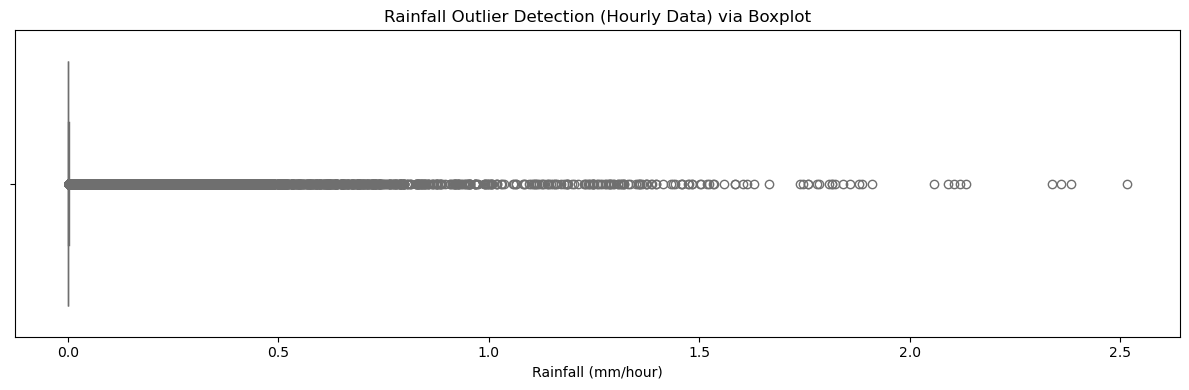

Detected 11016 outliers out of 52584 hourly records

ADF Test on "Original Hourly Rainfall":
  Test Statistic : -28.5507
  p-value        : 0.0000
  => Likely Stationary

ADF Test on "First Difference of Hourly Rainfall":
  Test Statistic : -49.9890
  p-value        : 0.0000
  => Likely Stationary


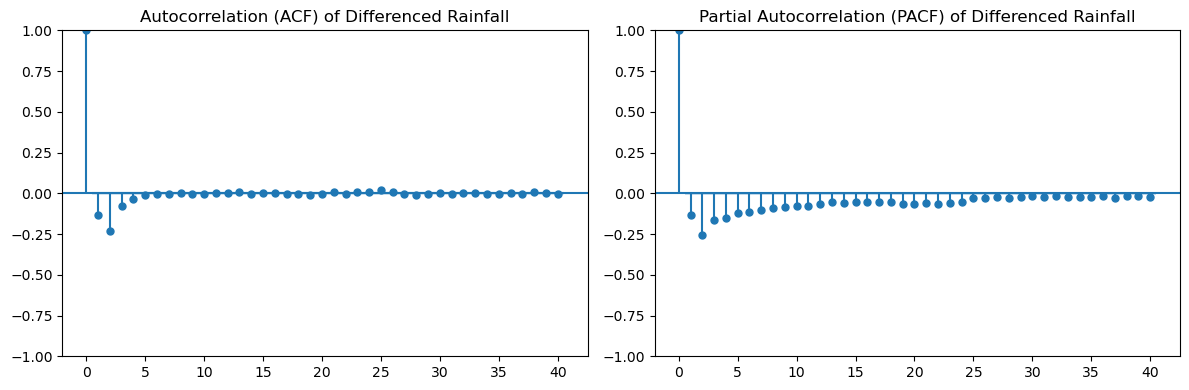

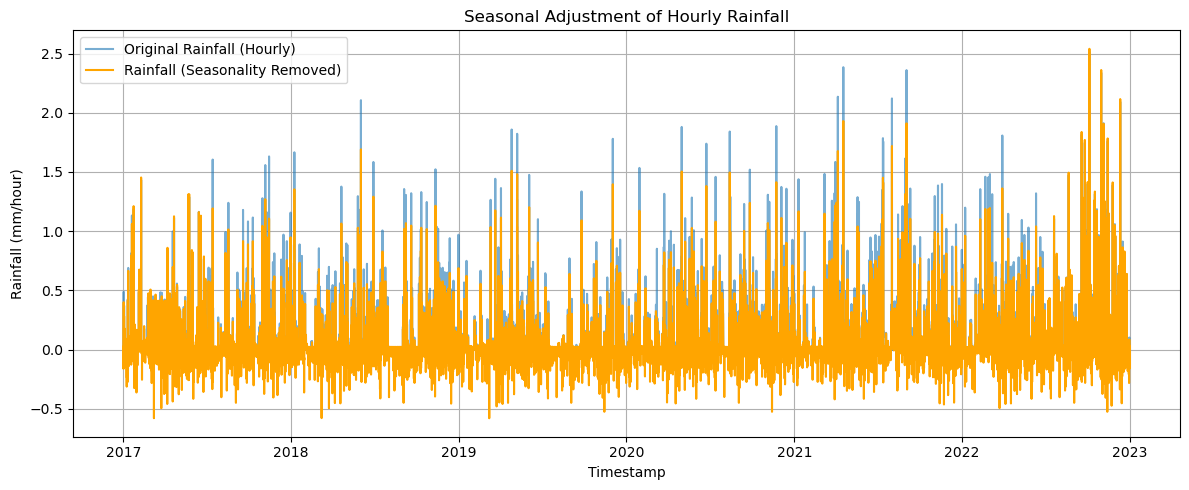

In [ ]:
ts = df["rainfall"].copy()
ts.index = pd.to_datetime(ts.index)
ts = ts.interpolate(method="time")  # Fill any small gaps

# --- Outlier Detection ---
plt.figure(figsize=(12, 4))
sns.boxplot(x=ts.values, color="skyblue", orient="h")
plt.title("Rainfall Outlier Detection (Hourly Data) via Boxplot")
plt.xlabel("Rainfall (mm/hour)")
plt.tight_layout()
plt.show()

# Detect outliers using IQR method
q1 = ts.quantile(0.25)
q3 = ts.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = ts[(ts < lower_bound) | (ts > upper_bound)]

print(f"Detected {len(outliers)} outliers out of {len(ts)} hourly records")

# --- Stationarity Check (ADF Test) ---
def adf_check(series, name="Series"):
    result = adfuller(series)
    print(f"\nADF Test on \"{name}\":")
    print(f"  Test Statistic : {result[0]:.4f}")
    print(f"  p-value        : {result[1]:.4f}")
    print("  => Likely Stationary" if result[1] < 0.05 else "  => Likely Non-stationary")

adf_check(ts, "Original Hourly Rainfall")

# First difference to check stationarity again
ts_diff = ts.diff().dropna()
adf_check(ts_diff, "First Difference of Hourly Rainfall")

# Plot ACF and PACF
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(ts_diff, lags=40, ax=plt.gca())
plt.title("Autocorrelation (ACF) of Differenced Rainfall")

plt.subplot(1, 2, 2)
plot_pacf(ts_diff, lags=40, ax=plt.gca(), method="ywm")
plt.title("Partial Autocorrelation (PACF) of Differenced Rainfall")
plt.tight_layout()
plt.show()

# Assume yearly seasonality (8760 hours = 365 days)
decomposition = seasonal_decompose(ts, model="additive", period=8760)
seasonal = decomposition.seasonal
seasonally_adjusted = ts - seasonal

# Plot original vs seasonally adjusted
plt.figure(figsize=(12, 5))
plt.plot(ts, label="Original Rainfall (Hourly)", alpha=0.6)
plt.plot(seasonally_adjusted, label="Rainfall (Seasonality Removed)", color="orange")
plt.title("Seasonal Adjustment of Hourly Rainfall")
plt.xlabel("Timestamp")
plt.ylabel("Rainfall (mm/hour)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Observations

##### **Outlier Detection**

- The boxplot shows a heavy left skew with most values tightly clustered near 0 mm/hour.
- There is a long right tail with many outliers extending beyond 2.5 mm/hour.
- This is typical of rainfall data:
  - Most hours have no or very little rain,
  - But a small number of hours have intense bursts (e.g. storms).
- Although there are 'outliers' on this box plot, these are typical of rainfall patterns and should not be treated as erroneous data.

#### **Stationarity Check (ACF & PACF)**

##### ACF (Autocorrelation Function):
- A sharp drop after lag 1 followed by values close to zero suggests the series is **stationary** after first differencing.
- The negative autocorrelation at lag 1 may reflect alternating rain/no-rain patterns (common in hourly data).

##### PACF (Partial Autocorrelation Function):
- PACF also decays quickly after lag 1.
- The series has short memory after differencing.

#### **Seasonal Adjustment**

- The seasonal component (using `period=8760`, i.e. yearly cycle) has been successfully removed.
- The orange line (seasonally adjusted series) retains much of the high-frequency variability while smoothing out long-term periodic fluctuations.
- Notably, the*amplitude of rainfall appears relatively stable across years.
